# Exploaracion de la data

In [1]:
import pandas as pd

## Cargamos los datos

In [2]:
from src.utils import load_data, ReadCsvParams, SaveCsvParams

file_path = '../data/raw/hotel_booking.csv'
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'
read_csv_params: ReadCsvParams = {'delimiter': ','}
save_csv_params: SaveCsvParams = {'sep': ','}

df_hotel: pd.DataFrame = load_data(
    file_path=file_path, url=url, read_csv_params=read_csv_params, save_csv_params=save_csv_params
)

Loading data from file: ../data/raw/hotel_booking.csv


In [3]:
# Mostramos para chequear
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,01/07/2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,01/07/2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,02/07/2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,02/07/2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,03/07/2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Eliminamos la data a no utilizar

In [4]:
# Eliminamos columnas que no aportan
columnas_a_eliminar = ['name', 'email', 'phone-number', 'credit_card', 'company', 'reservation_status', 'reservation_status_date', 'agent']
df_hotel.drop(columns=columnas_a_eliminar, inplace=True)

In [5]:
print("\nColumnas luego de eliminar las que no sirven:")
pd.DataFrame(df_hotel.columns, columns=['Columnas eliminadas'])


Columnas luego de eliminar las que no sirven:


,Columnas eliminadas
0,hotel
1,is_canceled
2,lead_time
3,arrival_date_year
4,arrival_date_month
5,arrival_date_week_number
6,arrival_date_day_of_month
7,stays_in_weekend_nights
8,stays_in_week_nights
9,adults


In [6]:
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,0,Transient,98.0,0,1


## Eliminamos los valores nulos

In [7]:
# Ahora analizamos los valores nulos
print("\nCantidad de valores nulos por columna:")
pd.DataFrame(df_hotel.isnull().sum())


Cantidad de valores nulos por columna:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [8]:
# Para ver también en porcentaje (opcional)
print("\nPorcentaje de valores nulos por columna:")
pd.DataFrame(df_hotel.isnull().sum() / len(df_hotel) * 100)


Porcentaje de valores nulos por columna:


,0
hotel,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


## Columnas sobre las que trabajar y sus tipo

In [9]:
# variable objetivo
target: str = 'is_canceled'

# columnas numericas
col_numericas: list[str] = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

# columnas categoricas
col_categoricas: list[str] = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# features
features = col_numericas + col_categoricas

# agrega a las clumnas categoricas la variable objetivo
col_categoricas = col_categoricas + [target]

## Graficos De Análisis

### Analisis de la variable objetivo (target)

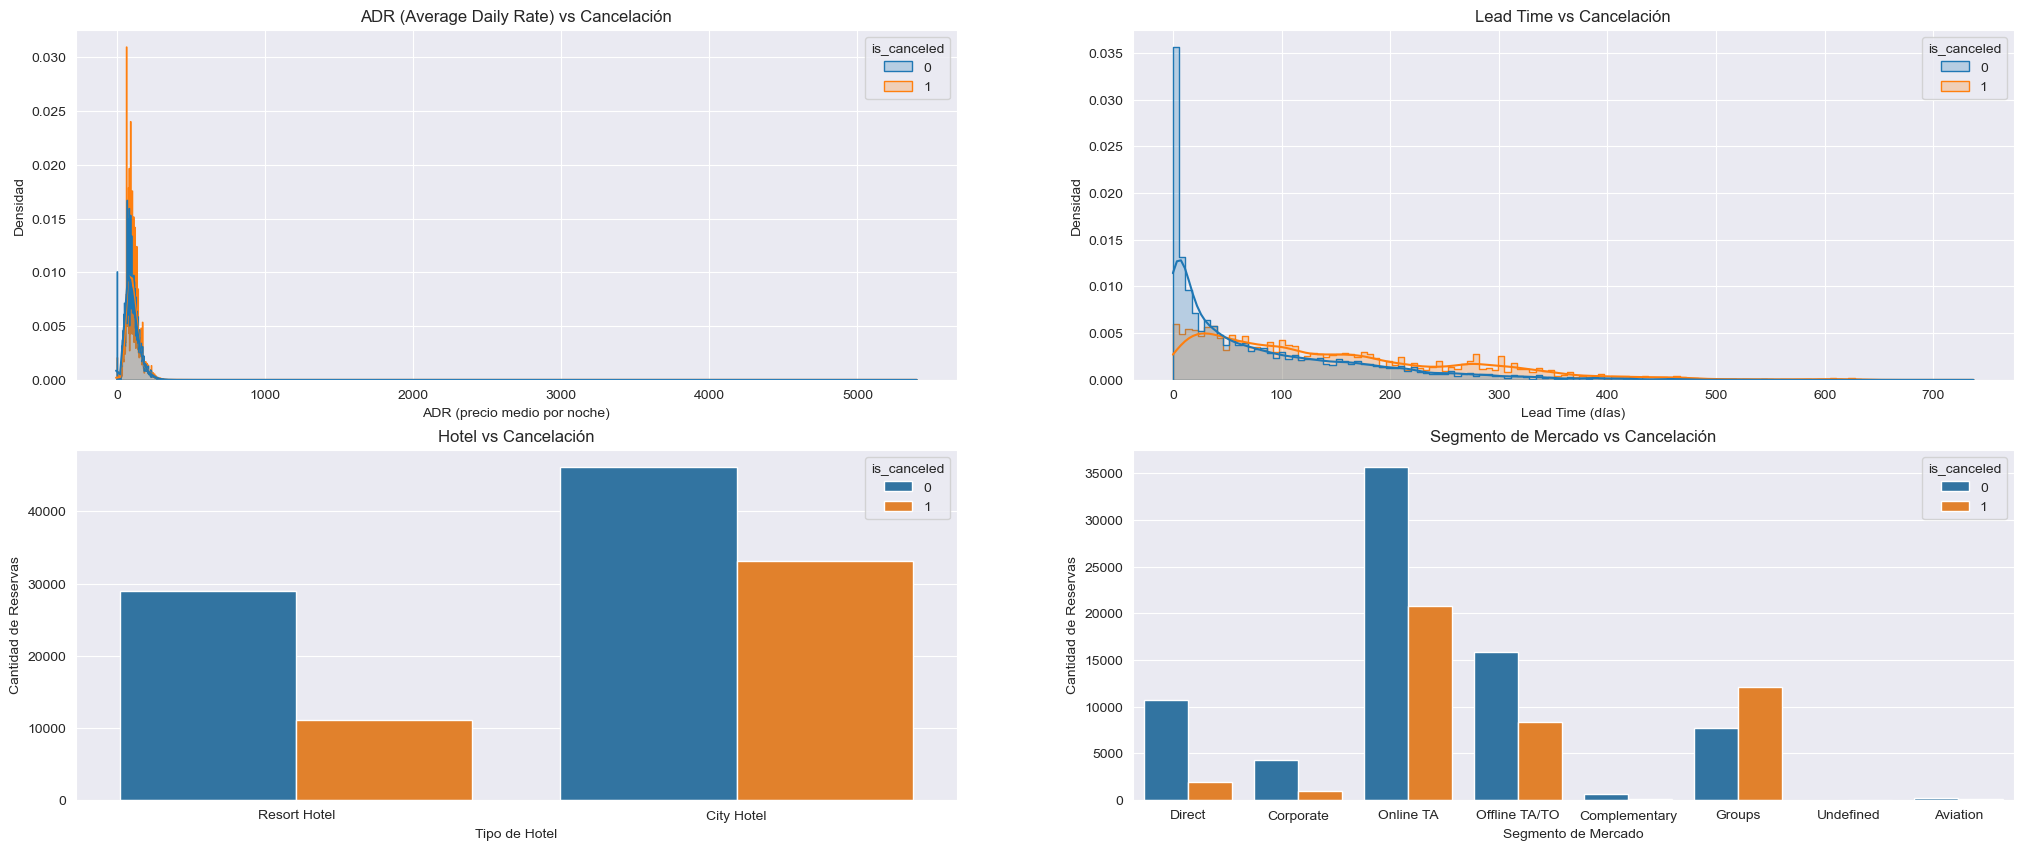

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

_, axis = plt.subplots(2, 2, figsize=(25, 10))

# 1. adr vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='adr', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 0]).set(
    title='ADR (Average Daily Rate) vs Cancelación',
    xlabel='ADR (precio medio por noche)',
    ylabel='Densidad',
)
# plt.xlim(0, 500)  # Limitar para que los outliers extremos no deformen el gráfico
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 2. lead_time vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='lead_time', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 1]).set(
    title='Lead Time vs Cancelación',
    xlabel='Lead Time (días)',
    ylabel='Densidad',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 3. hotel vs. cancelación
sns.countplot(data=df_hotel, x='hotel', hue='is_canceled', ax=axis[1, 0]).set(
    title='Hotel vs Cancelación',
    xlabel='Tipo de Hotel',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 4. market_segment vs. cancelación
sns.countplot(data=df_hotel, x='market_segment', hue='is_canceled', ax=axis[1, 1]).set(
    title='Segmento de Mercado vs Cancelación',
    xlabel='Segmento de Mercado',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])
# plt.xticks(rotation=45)


plt.show()

### Matriz de correlación entre las variables numéricas

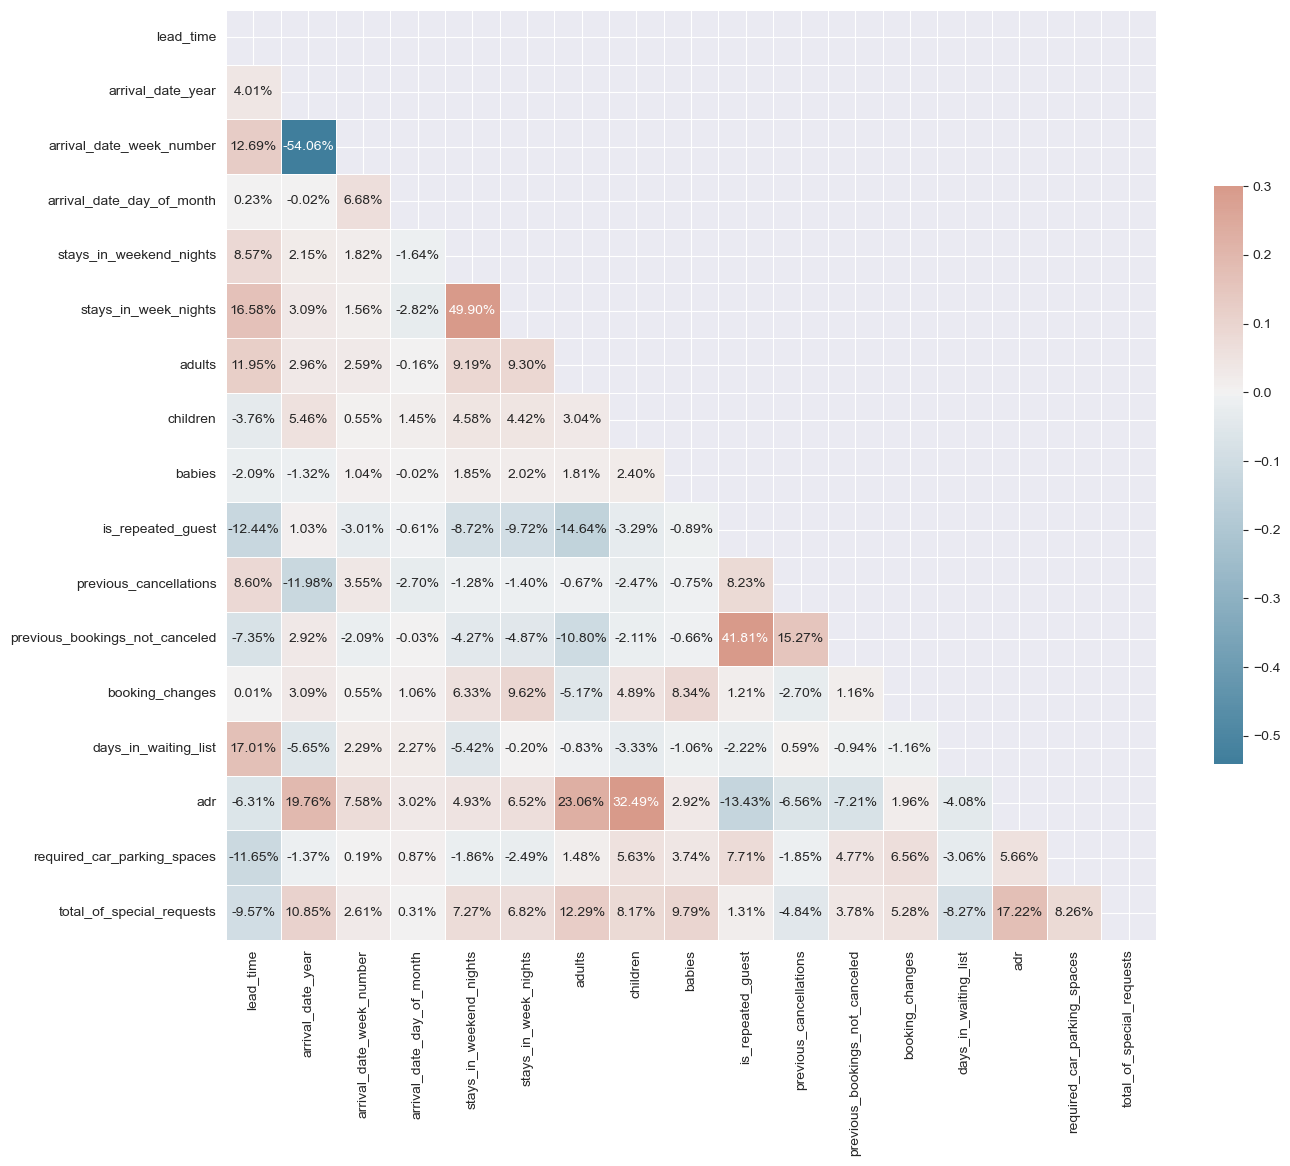

In [11]:
from src.draw_utils import draw_corr_matrix


# crea la matriz de correlacion de las variables numericas
corr = df_hotel[col_numericas].corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(15, 15))

### Matriz de correlación entre las variables categoricas

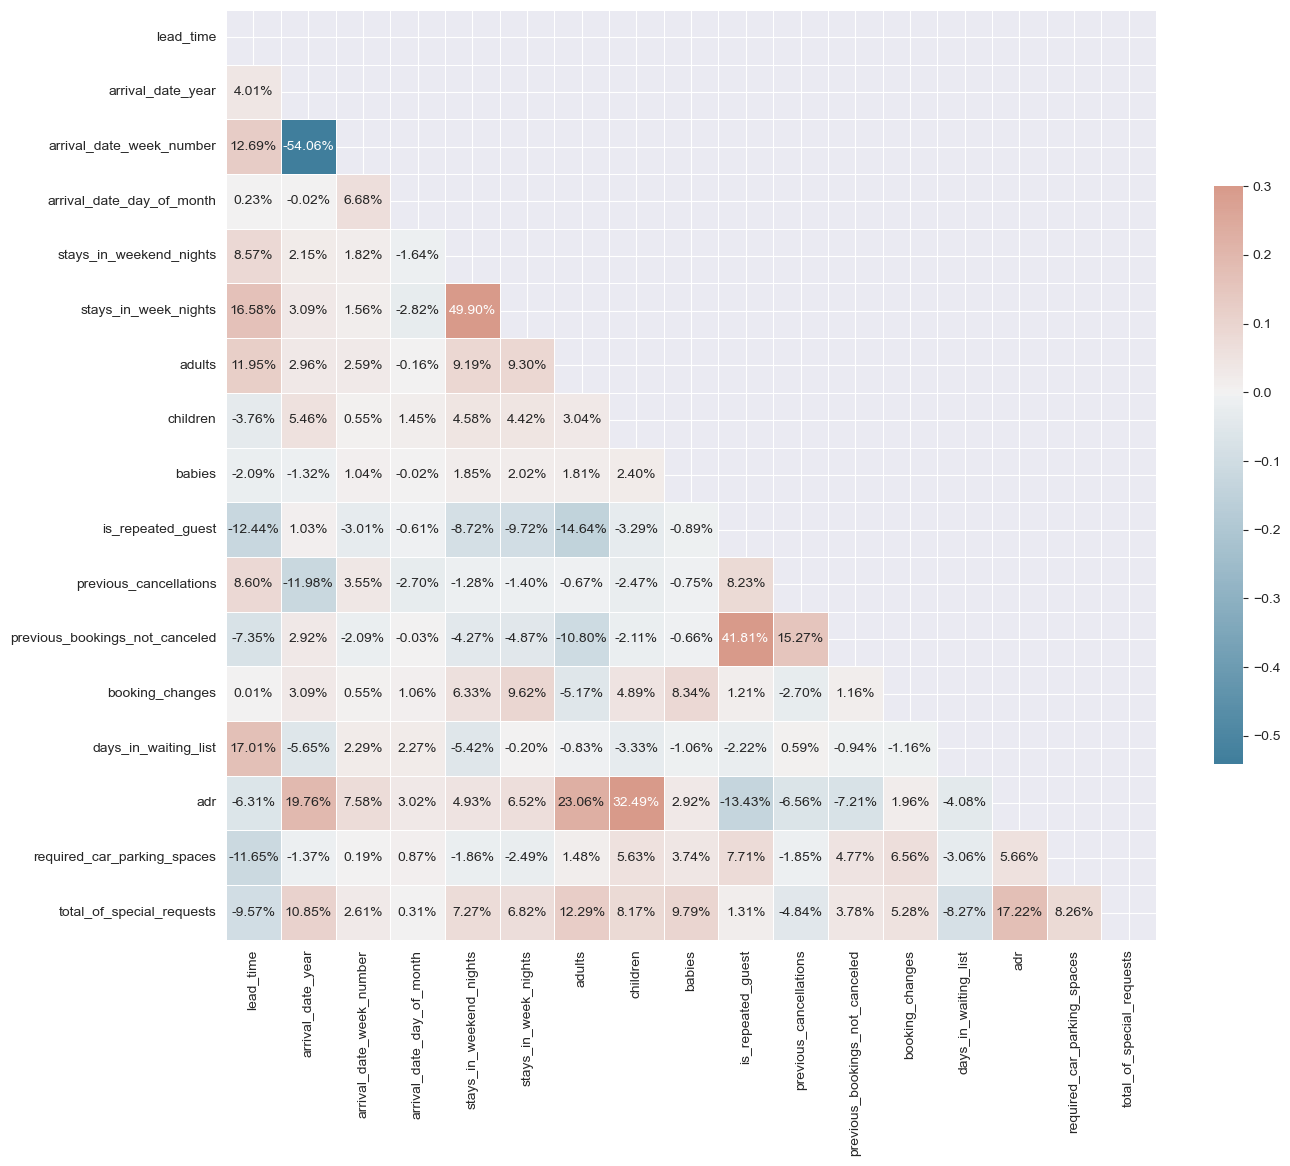

In [12]:
from src.draw_utils import draw_corr_matrix
from sklearn.preprocessing import LabelEncoder


# convertimos las variables categoricas a numericas usnado sklearn
df_hotel_encoded = df_hotel.copy()
label_encoders = {}

for column in col_categoricas:
    # crea el decoder
    le = LabelEncoder()

    # hacemos ajuste y tranformacion de la columna
    df_hotel_encoded[column] = le.fit_transform(df_hotel[column])

    # guardamos el encoder por si luego queremos invertir
    label_encoders[column] = le

# crea la matriz de correlacion de las variables categoricas
corr = df_hotel_encoded[col_numericas].corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(15, 15))

### Matriz de correlacion completa de todas las variables

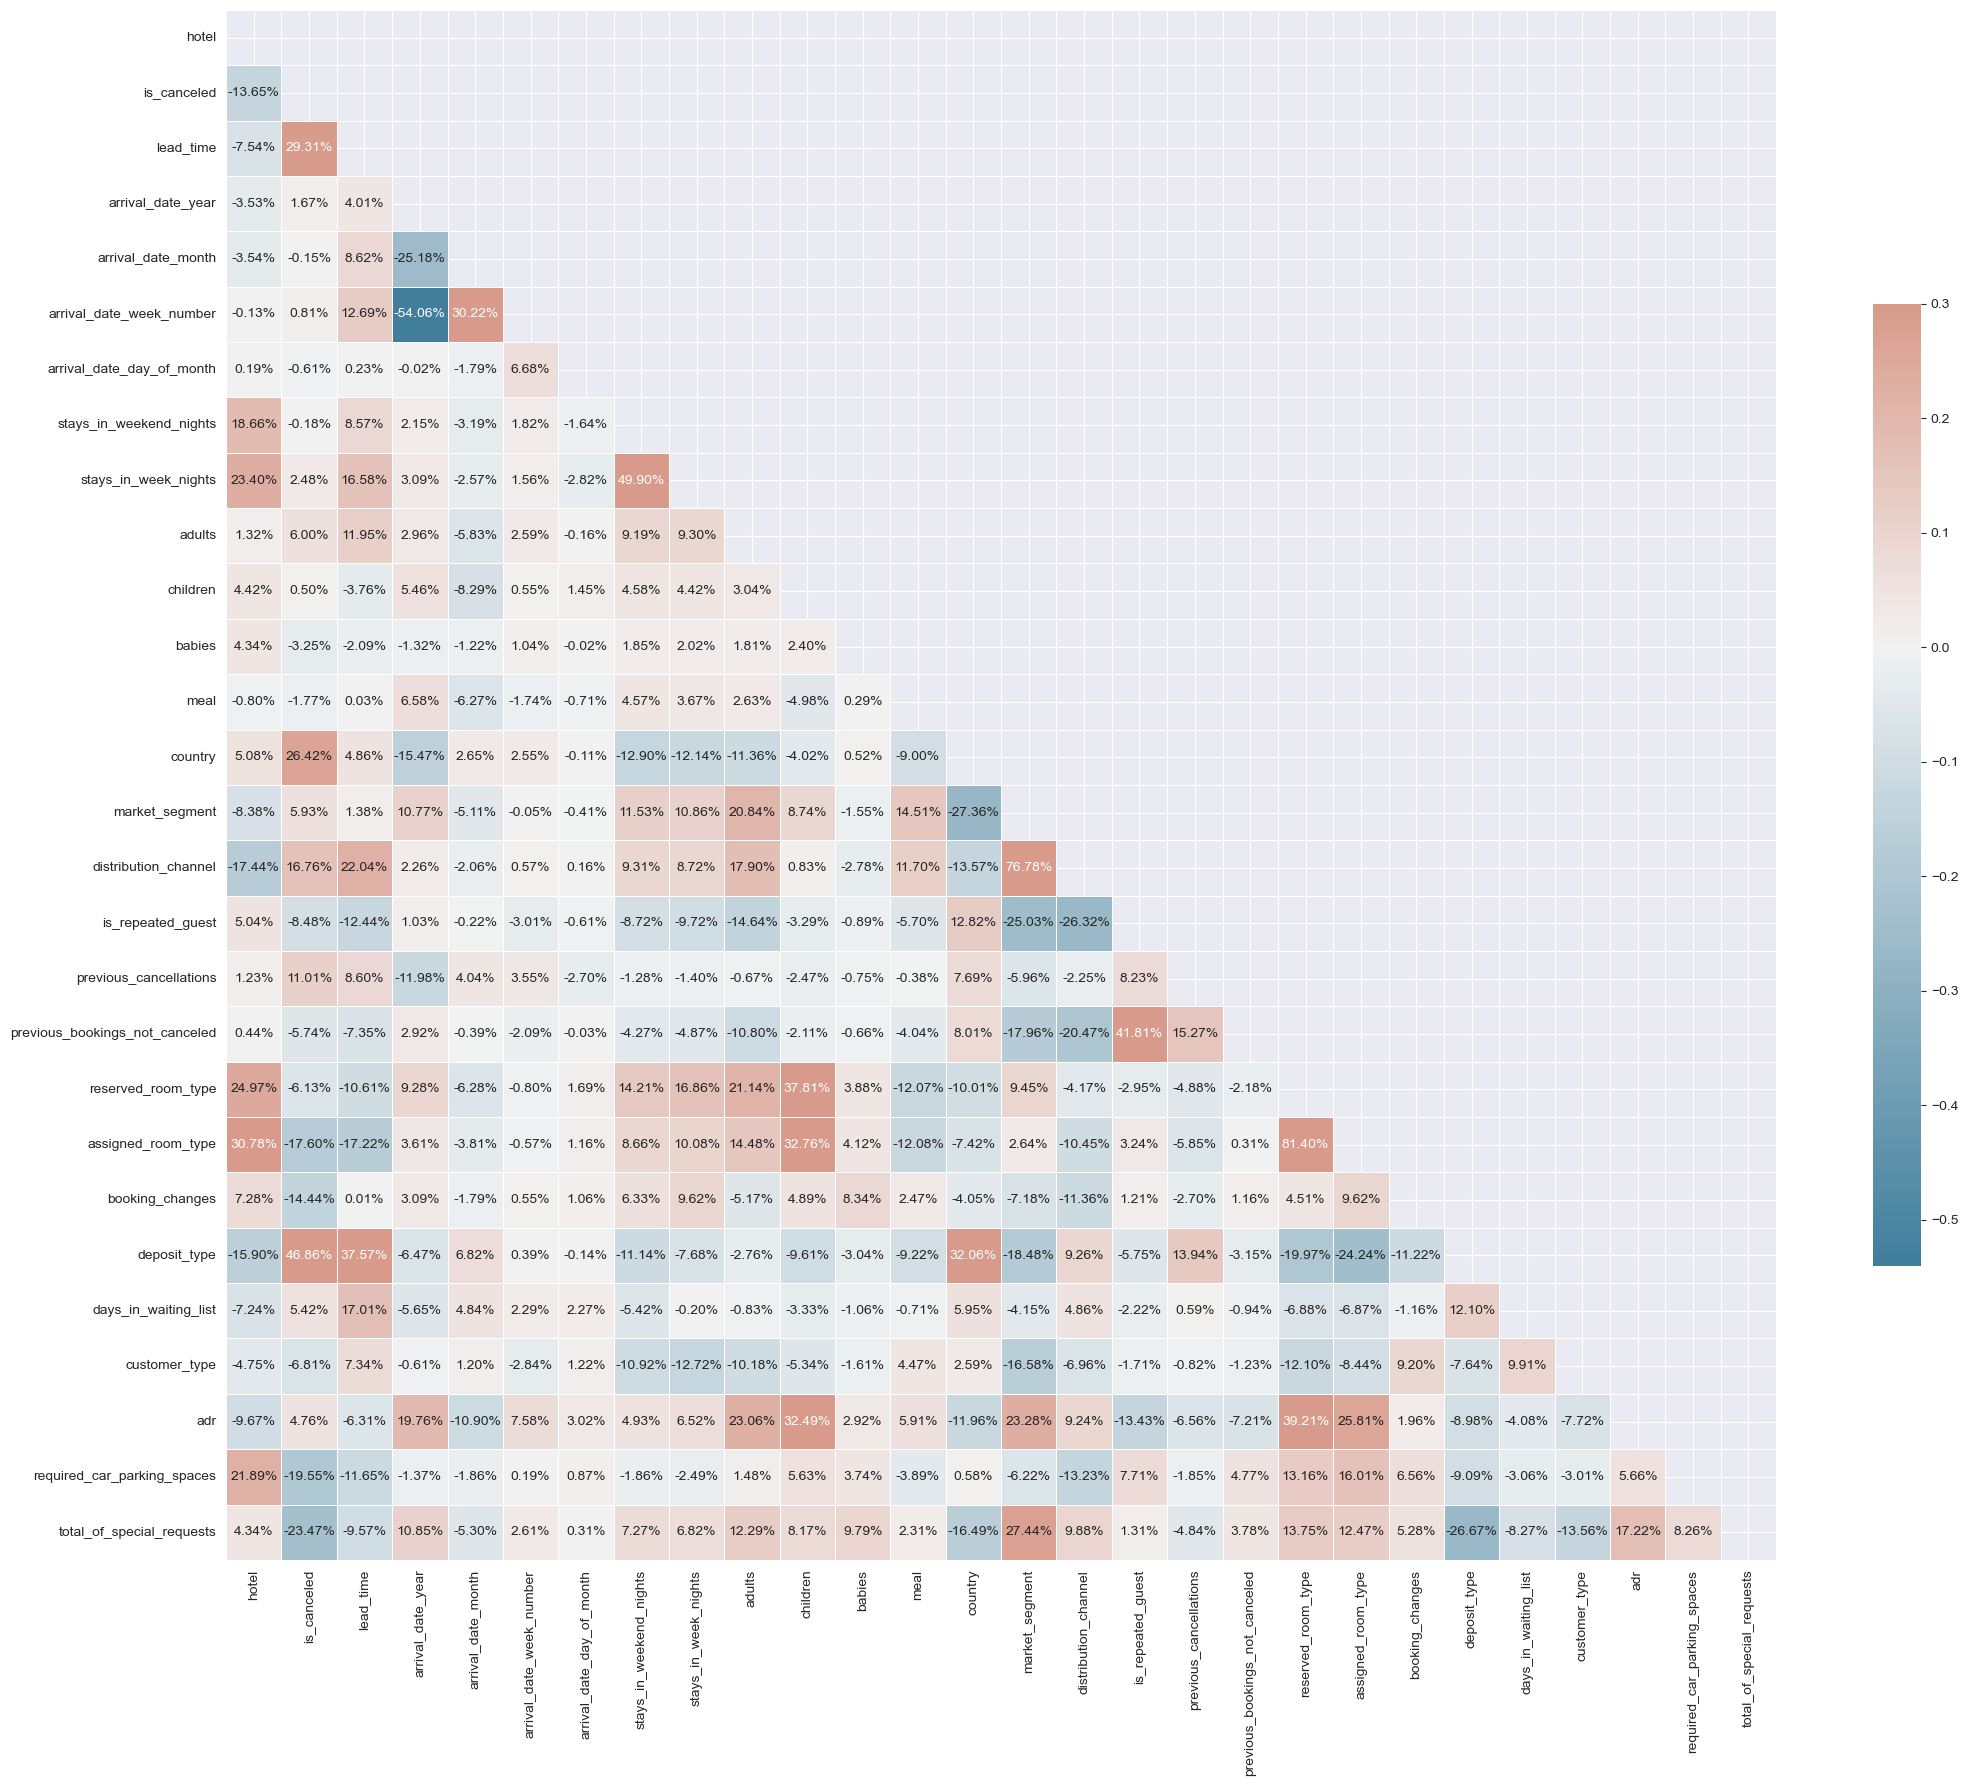

In [13]:
# crea la matriz de correlacion de todas las variables
corr = df_hotel_encoded.corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(25, 25))

A traves de estas matrices podemos hacer un analisis inicial, pero las decisiones sobre qué variables tomar y sacar se hara más adelante en el analisis del model.